In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp -r drive/MyDrive/IFT780/TP2/prog/* .

# TP2: Dropout

Dropout [1] est une technique de régularisation qui consiste à forcer aléatoirement à zéro certains neurones lors de la propagation avant. Pour cet exercice, vous serez appelé à coder une couche de dropout et de l'incorporer à votre réseau pleinement connecté.

Ceci est le notebook le plus court du tp2.  Nous utiliserons pour l'essentiel le code dans les fichiers suivants :

    model/Model.py
    layers/Dropout.py 
    utils/model_loss.py
    model/Solver.py
    
Comme au tp1, la classe **Model** "crée" un réseau de neurones en ajoutant successivement des couches et une fonction de perte.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012


In [2]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Pour automatiquement recharger les modules externes
# voir http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Charger la banque de données CIFAR-10, prétraiter les images et ajouter une dimension pour le biais.
    
    Input :
    - num_training : nombre d'images à mettre dans l'ensemble d'entrainement
    - num_validation : nombre d'images à mettre dans l'ensemble de validation
    - num_test : nombre d'images à mettre dans l'ensemble de test
    - num_dev : d'images à mettre dans l'ensemble dev
    
    Output :
    - X_train, y_train : données et cibles d'entrainement
    - X_val, y_val: données et cibles de validation
    - X_test y_test: données et cibles de test 
    - X_dev, y_dev: données et cicles dev
    """
    # Charger les données CIFAR-10
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test, label_names = load_CIFAR10(cifar10_dir)
  
    # Séparer en ensembles d'entraînement, de validation, de test et de dev
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalisation
    X_train -= np.mean(X_train, axis = 0)
    X_val -= np.mean(X_val, axis = 0)
    X_test -= np.mean(X_test, axis = 0)
    X_dev -= np.mean(X_dev, axis = 0)

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


def preprocess_CIFAR10_data(X):

    # Normalisation
    X_mean = np.mean(X, axis = 0)
    X_ = X - X_mean

    # Ajout du biais
    X_ = np.hstack([X_, np.ones((X.shape[0], 1))])
    
    return X_

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)
dev data shape:  (500, 3072)
dev labels shape:  (500,)


In [19]:
from layers.Dense import Dense
from layers.Dropout import Dropout
from model.Model import Model
from utils.model_loss import cross_entropy_loss

def create_toy_data(shape):
    np.random.seed(0)
    return np.random.randn(*shape) + 10

X = create_toy_data((500,500))
print(X.shape)

(500, 500)


# Propagation avant

Dans le fichier `Dropout.py`, codez la propagation avant du dropout. Puisque dropout se comporte différemment en entraînement qu'en test, assurez-vous que les deux modes fonctionnent bien.

Exécutez la cellule que voici et assurez-vous que la moyenne de out_train soit la même que out_test.

NOTE : vous devez implémenter du "inverse dropout".  Pour plus de détail, voir https://deepnotes.io/dropout

In [20]:
##############################################################################
# TODO: Implémenter la méthode forward (propagation avant) de la classe de   #
# couche Dropout. Le comportement lors de l'entraînement et des tests est    #
# différent, assurez-vous donc que les deux fonctionnent.                    #
##############################################################################

for p in [0.3, 0.6, 0.75]:
    dropout_layer = Dropout(drop_rate=p)
    out_train = dropout_layer.forward(X, mode='train')
    out_test = dropout_layer.forward(X, mode='test')

    print('Running tests with p = ', p)
    print('Mean of input: ', X.mean())
    print('Mean of train-time output: ', out_train.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out_train == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    print()


Running tests with p =  0.3
Mean of input:  10.001537191397109
Mean of train-time output:  9.999626974532692
Mean of test-time output:  10.001537191397109
Fraction of train-time output set to zero:  0.299984
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.6
Mean of input:  10.001537191397109
Mean of train-time output:  10.038205232419314
Mean of test-time output:  10.001537191397109
Fraction of train-time output set to zero:  0.598564
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.75
Mean of input:  10.001537191397109
Mean of train-time output:  10.032345359229108
Mean of test-time output:  10.001537191397109
Fraction of train-time output set to zero:  0.749196
Fraction of test-time output set to zero:  0.0



In [21]:
from utils.gradients import evaluate_numerical_gradient

# Retourne l'erreur relative maximale des matrices de gradients passées en paramètre.
# Pour chaque paramètre, l'erreur relative devrait être inférieure à environ 1e-8.
def rel_error(x, y):
    rel = np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y)))
    return np.max(rel)

# Dropout: rétro-propagation
Toujours dans le fichier `Dropout.py`, codez la rétro-propagation du dropout. Vous pourrez par la suite tester votre code avec la cellule que voici.

In [25]:
##############################################################################
# TODO: Implémenter la méthode backward (propagation arrière) de la classe de#
# couche Dropout. Le comportement lors de l'entraînement et des tests est    #
# différent, assurez-vous donc que les deux fonctionnent.                    #
##############################################################################

X = create_toy_data((10,10))
dA = np.random.randn(*X.shape)

dropout_layer = Dropout(drop_rate=0.8)

_ = dropout_layer.forward(X, mode='train')
dX = dropout_layer.backward(dA, mode='train')

drop_mask = dropout_layer.cache

# L'erreur relative devrait être très petite, inférieure à 1e-8
rel_error(dX, drop_mask * dA / 0.2)  # Enlever le 0.2 si vous l'avez inclut dans dropout_layer.cache

2.2136490514694084e-16

# Réseau multi-couches avec Dropout
En principe, le code que voici devrait fonctionner.

In [37]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D) / 5
y = np.random.randint(C, size=(N,))

seed = 42

for p in [0, 0.25, 0.5]:
    print('Running check with dropout = ', p)
    model = Model()
    
    dense1 = Dense(dim_input=D, dim_output=H1, weight_scale=5e-2, activation='relu')
    dropout1 = Dropout(drop_rate=p)
    
    dense2 = Dense(dim_input=H1, dim_output=H2, weight_scale=5e-2, activation='relu')
    dropout2 = Dropout(drop_rate=p)
    
    dense3 = Dense(dim_input=H2, dim_output=C, weight_scale=5e-2)
    dropout3 = Dropout(drop_rate=p)
    
    model.add(dense1, 'dense1')
    model.add(dropout1, 'dropout1')
    model.add(dense2, 'dense2')
    model.add(dropout2, 'dropout2')
    model.add(dense3, 'dense3')
    model.add(dropout3, 'dropout3')
    model.add_loss(cross_entropy_loss)
    
    
    out = model.forward(X, seed=seed)
    
    loss, dScores, _ = model.calculate_loss(out, y, 0.0)
    _ = model.backward(dScores)

    gradients = model.gradients()
    model_params = model.parameters()
    
    print('Initial loss: ', loss)
    print('out = ', out)
    # Les erreurs devraient être inférieures ou égales à 1e-5
    for layer_name, layer_params in model_params.items():
        for param_name, _ in layer_params.items():
            grad_num = evaluate_numerical_gradient(X, y, model, layer_name, param_name, reg=0.0, seed=seed)
            max_error = rel_error(grad_num, gradients[layer_name][param_name])

            print('%s max relative error: %e' % (layer_name + '-' + param_name, max_error))

Running check with dropout =  0
Initial loss:  2.303136960427925
out =  [[-4.59919260e-03  2.24249570e-03 -1.04173991e-03 -5.26610207e-03
  -1.10487327e-04  2.44597436e-03  4.64793960e-03 -5.50949288e-04
   7.19461508e-04  4.02879988e-04]
 [-4.49446427e-04  1.26977960e-04  4.28958308e-04 -6.91753755e-04
   6.32536428e-04  2.32109844e-04  3.87263858e-04  7.88197382e-04
   1.21775137e-04 -1.22665963e-05]]
dense1-W max relative error: 9.599900e-07
dense1-b max relative error: 4.859826e-09
dense2-W max relative error: 5.417810e-06
dense2-b max relative error: 2.144697e-09
dense3-W max relative error: 6.298536e-07
dense3-b max relative error: 1.316700e-10
Running check with dropout =  0.25
Initial loss:  2.303067476423432
out =  [[-1.43714355e-03  0.00000000e+00 -1.66876341e-03  7.23116471e-04
   1.06411656e-03  2.56971371e-03  2.24003599e-03 -0.00000000e+00
   2.88212755e-03  9.82869006e-04]
 [-2.85457853e-03 -0.00000000e+00  0.00000000e+00 -9.62211733e-05
   1.74164120e-03  4.56992276e-04

# Expérimentation
Ici nous entrainerons 2 réseaux de neurones avec 500 données: l'un utilisera du dropout et l'autre non. Nous pourrons alors visualiser les justesses obtenues en entraînement et en validation.

In [38]:
##############################################################################
# Tester l'optimiseur Adam (voir fichier model/Solver.py)                    #
##############################################################################

from model.Solver import epoch_solver, Adam

num_train = 500

X_train_small = X_train[:num_train]
y_train_small = y_train[:num_train]


train_accuracy_histories = []
val_accuracy_histories = []

dropouts = [0, 0.3]

for p in dropouts:
    model = Model()
    
    dense1 = Dense(dim_output=500, weight_scale=1e-2, activation='relu')
    dropout1 = Dropout(drop_rate=p)
    
    dense2 = Dense(dim_input=500, weight_scale=1e-2)
    dropout2 = Dropout(drop_rate=p)
    
    model.add(dense1, 'dense1')
    model.add(dropout1, 'dropout1')
    model.add(dense2, 'dense2')
    model.add(dropout2, 'dropout2')
    model.add_loss(cross_entropy_loss)
    
    print('\nDropout: ', p, '\n')
    
    optimizer = Adam(1e-4, model)
    
    _, train_accuracy_history, val_accuracy_history = epoch_solver(X_train_small, 
                                                                   y_train_small,
                                                                   X_val,
                                                                   y_val,
                                                                   0.0,
                                                                   optimizer,
                                                                   epochs=20)
    
    train_accuracy_histories.append(train_accuracy_history)
    val_accuracy_histories.append(val_accuracy_history)


Dropout:  0 

(epoch 1 / 20) loss: 6.368419, train_acc: 0.396000, val_acc: 0.235000
(epoch 2 / 20) loss: 2.850362, train_acc: 0.536000, val_acc: 0.264000
(epoch 3 / 20) loss: 1.991403, train_acc: 0.694000, val_acc: 0.288000
(epoch 4 / 20) loss: 0.872848, train_acc: 0.858000, val_acc: 0.291000
(epoch 5 / 20) loss: 0.692343, train_acc: 0.946000, val_acc: 0.301000
(epoch 6 / 20) loss: 0.134229, train_acc: 0.970000, val_acc: 0.299000
(epoch 7 / 20) loss: 0.075945, train_acc: 0.998000, val_acc: 0.304000
(epoch 8 / 20) loss: 0.061014, train_acc: 0.994000, val_acc: 0.303000
(epoch 9 / 20) loss: 0.021047, train_acc: 1.000000, val_acc: 0.295000
(epoch 10 / 20) loss: 0.012227, train_acc: 1.000000, val_acc: 0.308000
(epoch 11 / 20) loss: 0.020495, train_acc: 1.000000, val_acc: 0.312000
(epoch 12 / 20) loss: 0.006422, train_acc: 1.000000, val_acc: 0.309000
(epoch 13 / 20) loss: 0.006965, train_acc: 1.000000, val_acc: 0.304000
(epoch 14 / 20) loss: 0.006785, train_acc: 1.000000, val_acc: 0.309000


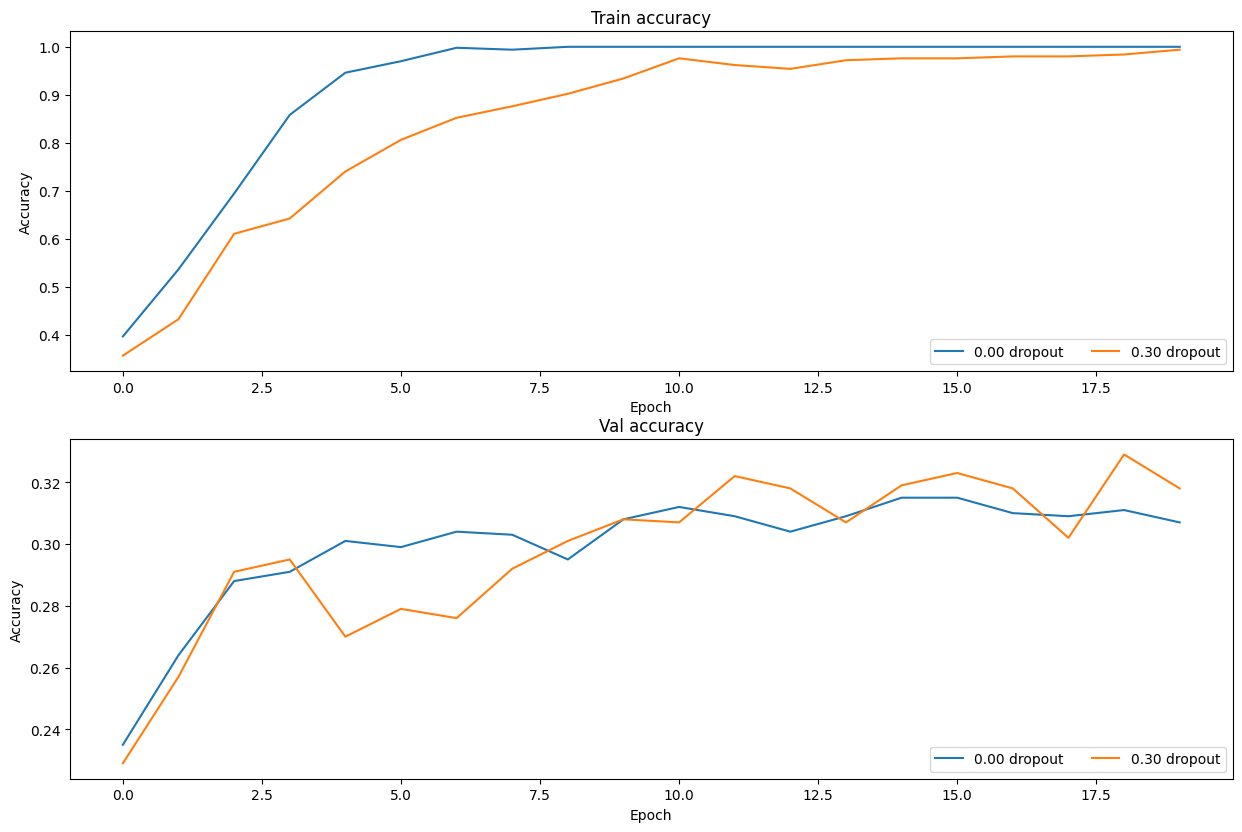

In [39]:
plt.subplot(3, 1, 1)
for i in range(2):
  plt.plot(train_accuracy_histories[i], '-', label='%.2f dropout' % dropouts[i])
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for i in range(2):
  plt.plot(val_accuracy_histories[i], '-', label='%.2f dropout' % dropouts[i])
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()